# Buckminsterfullerene

In [1]:
# run the first cell before presentation

import bubblebox as bb
from bubblebox.mdbox import lj_force, hook_force, no_force, coulomb_force
import numpy as np
import matplotlib.pyplot as plt

def ring_connector(ring_configuration, connection_pattern = None):
    
    connections = []
    
    
    # create unconnected rings
    for i in range(len(ring_configuration)):
        # shift indices of rings
        dR = int(np.sum(ring_configuration[:i]))
        
        # create current ring
        current_connections = []
        for j in range(ring_configuration[i]):
            current_connections.append([(1+j)%ring_configuration[i]+dR,(-1+j)%ring_configuration[i]+dR])
        
        connections.append(current_connections)
        
    
    unconnected_edges = ring_configuration*1
    
    # connect rings sucessively
    for i in range(len(ring_configuration)-1):
        
        # how many exterior sites per internal site?
       
        inner = np.linspace(-1,1,unconnected_edges[i]+1)[:-1]
        outer = np.linspace(-1,1,ring_configuration[i+1]+1)[:-1]
        
        ci = np.argmin((inner[:, None] - outer[None, :])**2, axis = 1)

        
        if connection_pattern is None:


            inc = ring_configuration[i+1]/ unconnected_edges[i]
            #print("increment:", inc)

            k = 0


            for j in range(ring_configuration[i]):
                if len(connections[i][j])<3:
                    connect_k = (int(np.ceil(k*inc))+i//2)%ring_configuration[i+1]
                    connections[i  ][j].append(connect_k + np.sum(ring_configuration[:i+1]))
                    connections[i+1][connect_k].append(j + np.sum(ring_configuration[:i]))


                    #book-keeping
                    unconnected_edges[i+1] -= 1
                    unconnected_edges[i  ] -= 1

                    k += 1
        else:
            nc = len(connection_pattern[i])
            
            
            repeat_times = ring_configuration[i+1]/nc
            

            
            
            connection_i = []# 
            for j in range(int(repeat_times)):
                connection_i += connection_pattern[i]
                
            outer_connection_sites = np.arange(ring_configuration[i+1])[np.array(connection_i)]
            
            k = 0
            for j in range(ring_configuration[i]):
                if len(connections[i][j])<3:
                    #print("connecting")
                    connect_k = outer_connection_sites[k]
                    connections[i  ][j].append(connect_k + np.sum(ring_configuration[:i+1]))
                    connections[i+1][connect_k].append(j + np.sum(ring_configuration[:i]))


                    #book-keeping
                    unconnected_edges[i+1] -= 1
                    unconnected_edges[i  ] -= 1

                    k += 1
                    
                
    # create final graph
    graph = []
    for layer in connections:
        for connectivity in layer:
            graph.append(connectivity)

            
    graph = np.array(graph)
    

    return graph

def connected_structure(connection_indices, n_dimensions = 3):
    n_atoms = connection_indices.shape[0]
    
    
    b = bb.bubblebox.mdbox(n_bubbles = n_atoms, size = (np.ones(n_dimensions, dtype = float)*20).tolist())
    

    
    b.set_forces(coulomb_force, force_params = np.array([7.0,7.0]))
    
    
    
    for i in range(n_atoms):
        # connect atom i to the respective atoms
        bubbles_a = np.zeros(n_atoms, dtype = bool)
        bubbles_a[i] = True
            
        for j in range(len(connection_indices[i])):
            
            
            bubbles_b = np.zeros(n_atoms, dtype = bool)
            bubbles_b[connection_indices[i,j]] = True
            
            #print(bubbles_a, bubbles_b)
            
            b.set_forces(hook_force, bubbles_a = bubbles_a, bubbles_b = bubbles_b, force_params = np.array([20,3]))
    b.r2_cut = 100000
    #b.pos += np.random.multivariate_normal(np.zeros(3), np.eye(3)*.1, n_atoms).T
    #b.pos = b.pos[:, np.random.choice(n_atoms, n_atoms, replace = False)]
    b.pair_list_update_frequency = 2
    return b

# visualize ring

def show_graph(ring_configuration, connectivity):
    
    
    pos = np.zeros((3, np.sum(ring_configuration)), dtype = float)
    
    count = 0
    
    count_sum = np.cumsum(ring_configuration)
    for i in range(len(ring_configuration)):
        t = np.linspace(0,2*np.pi, ring_configuration[i]+1)[:-1] 
        #print(int(np.sum(ring_configuration[:i])),int(np.sum(ring_configuration[:i])+ring_configuration[i]))
        pos[:,int(np.sum(ring_configuration[:i])):int(np.sum(ring_configuration[:i])+ring_configuration[i])] = np.array([(i+1)*np.sin(t), (i+1)*np.cos(t), 0*t])
                   
    #print(pos)
    plt.figure(figsize = (8,8))
    plt.plot(pos[0], pos[1], "o", color = (0,0,0))
    
    for i in range(len(connectivity)):
        pi = pos[:,i]
        for j in range(len(connectivity[i])):
            pj = pos[:, int(connectivity[i,j])]
            
            plt.plot([pi[0], pj[0]], [pi[1], pj[1]], "-", color = (0,0,0), zorder = -1)
            
            
            
        
    plt.axis("off")
    plt.show()
    return pos

connection_pattern = [[False, True , False],
[False, False, True, True],
[True, False, True],
[True]] #working


#connection_pattern = [[True, False , False],
#[False, True, True, False],
#[False, True, True],
#[True]]

ring = np.array([5,15,20,15,5]) #c60

m = ring_connector(ring, connection_pattern)

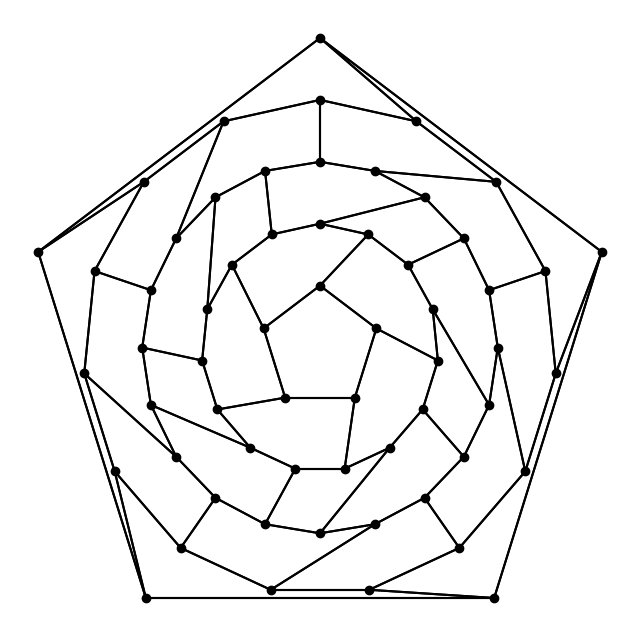

In [2]:
pos = show_graph(ring, m)

In [3]:
b = connected_structure(np.array(m, dtype = int))
b.pos = pos
b.pos[2] += .1*np.sqrt(pos[0]**2 + pos[1]**2)
b.view()

MDView(bg_color=[1.0, 1.0, 1.0], box=[20.0, 20.0, 20.0], colors=[[0.1349591171516541, 0.6639332296569468, 0.98…

In [4]:
# relax structure

for i in range(10000):
    for j in range(3):
        b.advance()
    b.vel_ *= 0.99
    b.update_view()

In [5]:
import evince as ev

b.pos *= 2
bonds = ev.spotlight.extract_bonds(b)
mv = ev.SpotlightView(b, window_scale_height=1.0,window_scale_width=1.0, realism = True, sao = True, dof = True, fxaa = True, bonds = bonds, bg_color = [0.0,0.05,0.0], focus = 8, aperture = .0010, max_blur = .01,
                 saoScale = 360, saoIntensity = 1.5, saoKernelRadius=1, saoMinResolution=100)

mv

SpotlightView(aperture=0.001, bg_color=[0.0, 0.05, 0.0], bonds=[[0, 1], [0, 4], [0, 6], [1, 2], [1, 9], [2, 3]…